# Pre-trained Model: VGG16

**VGG16: A Deep Convolutional Neural Network for Image Classification**

**Key Features:**

**16 Layers:** It has 13 convolutional layers and 3 fully connected layers, hence the name "VGG16."

**Small Filters:** It uses small 3x3 filters, stacked in succession for effective feature extraction.

**Simple Architecture:** It maintains a consistent structure, making it easy to understand and implement.

**ImageNet Training:** It's pre-trained on the massive ImageNet dataset, containing over 14 million images and 1000 classes.

**Architecture:**

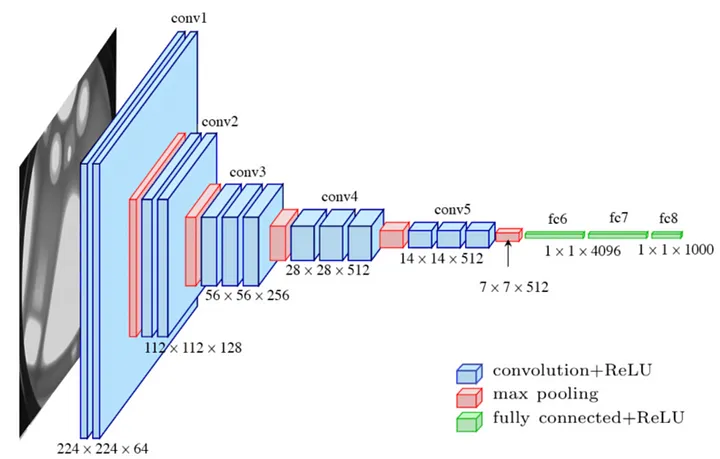

**Reference:**

Yang, Dandi & Martinez-Rendon, Cristhian & Visuña Pérez, Lara & Khandhar, Hardev & Bhatt, Chintan & Carretero, Jesus. (2021). Detection and analysis of COVID-19 in medical images using deep learning techniques. Scientific Reports. 11. 19638. 10.1038/s41598-021-99015-3.

**Initial Use:**

**Image Classification:** Its primary use was to classify images into 1000 different categories with high accuracy (92.7% on ImageNet).
Feature Extraction: It's often used to extract meaningful features from images, which can then be used for other tasks like object detection, style transfer, and image generation.

# Transfer Learning

Transfer learning is a machine learning technique where a model trained on one task is adapted for a different but related task. Instead of starting the learning process from scratch, transfer learning leverages knowledge gained from solving one problem and applies it to a different, yet related, problem.

The usefulness of transfer learning lies in its ability to improve the performance of a model on a target task with limited labeled data. It capitalizes on the features learned from a source task, which might have a large amount of available data, and transfers this knowledge to the target task, where data may be scarce or expensive to obtain. This approach can lead to faster training times, better generalization, and improved accuracy, especially in situations where collecting sufficient labeled data for a specific task is challenging.

## Import Libraries

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

## Dataset

The CIFAR-10 dataset is a widely used benchmark in the field of computer vision and machine learning. It consists of 60,000 32x32 color images, with 10 different classes, each representing a distinct object category. These classes include common objects such as airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset is evenly distributed, with 6,000 images per class, making it suitable for training and evaluating machine learning models. CIFAR-10 serves as a standard testbed for researchers and practitioners to assess the performance of image classification algorithms. Its relatively small image size and diverse set of objects make it a challenging dataset, encouraging the development of robust and efficient models capable of handling real-world image recognition tasks. Researchers often use CIFAR-10 to validate and compare the performance of different neural network architectures, particularly in the context of convolutional neural networks (CNNs).

### Preprocessing the dataset


In the preprocessing stage, the CIFAR-10 dataset is partitioned into training and testing subsets, denoted as `(X_train, y_train)` and `(X_test, y_test)`, respectively, employing the `cifar10.load_data()` function. Subsequently, pixel normalization is applied to the image data, wherein each pixel value is rescaled to the range [0, 1] by converting the data type to `float32` and dividing by 255.0. This normalization facilitates enhanced convergence during model training. Concurrently, categorical encoding is performed on the class labels using one-hot encoding. The integer-based class labels in y_train and y_test are transformed into binary vectors of length 10, corresponding to the 10 distinct categories in the CIFAR-10 dataset. The utilization of the to_categorical function ensures the appropriate conversion of class labels, aligning with the requisite format for categorical classification tasks. These meticulous preprocessing steps collectively serve to optimize the CIFAR-10 dataset for subsequent model training, adhering to established conventions for effective neural network convergence and classification accuracy.

Furthermore, to accommodate the VGG16 model's input size expectations, an additional preprocessing step is introduced. The images in both the training and testing sets are upsampled to match the dimensions of 224x224 pixels, as required by the VGG16 architecture. The tf.image.resize function is utilized for this purpose, ensuring that the images conform to the input size expected by the transfer learning model. This meticulous preprocessing, combining pixel normalization and image upsampling, collectively optimizes the CIFAR-10 dataset for subsequent transfer learning with VGG16, adhering to established conventions for effective neural network convergence and classification accuracy.

In [30]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Loading Pre-trained VGG-16 model

In [31]:
base_model = VGG16(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Freezing the base layers

Freezing the initial 15 layers of the VGG16 model serves as a strategic approach in transfer learning for several compelling reasons. In convolutional neural networks (CNNs), the early layers are responsible for capturing fundamental visual features such as edges, colors, and basic textures. These low-level features, pre-learned during the model's training on the extensive ImageNet dataset, are valuable across a wide range of computer vision tasks. By setting these initial layers as non-trainable, the model retains the generic knowledge encoded in these features while allowing the subsequent layers to adapt and specialize to the nuances of a new task. This not only prevents overfitting, particularly when dealing with limited task-specific data, but also optimizes computational efficiency by reducing the number of parameters that need updating during training. In essence, freezing the early layers aligns with the transfer learning principle of leveraging existing knowledge to enhance performance on a related task, making the training process more efficient and the model more adaptable to specific visual recognition challenges.

In [32]:
for layer in base_model.layers[:15]:
    layer.trainable = False

## Add New Classifier Layers

The VGG16 model, renowned for its effectiveness in image classification tasks, serves as a powerful feature extractor. In the given transfer learning scenario, all layers of the VGG16 model have been frozen (set to `layer.trainable = False`), preserving the pre-trained weights and leveraging the knowledge acquired during training on the ImageNet dataset. To adapt the model for a new task, additional layers have been appended to the VGG16 base. The initial UpSampling2D layer is employed to increase the spatial dimensions of the input, aligning it with the desired resolution of 224x224. This ensures compatibility between the original VGG16 model, which was trained on larger images, and the current input size.

Subsequently, a Flatten layer is introduced to transform the multidimensional output from the base model into a flat vector, facilitating the transition to densely connected layers. BatchNormalization layers enhance training stability by normalizing the activations. Following these normalization layers, two Dense layers are incorporated, introducing non-linearity and complexity to the model. The first Dense layer consists of 128 units with ReLU activation, capturing intricate patterns and features in the data. To prevent overfitting, a Dropout layer is strategically placed, randomly deactivating neurons during training. Another BatchNormalization layer ensures the stability of the subsequent Dense layer, which consists of 64 units activated by ReLU.

The final Dense layer, comprising 10 units with a softmax activation function, is designed for multi-class classification. This layer produces probability distributions over the target classes, enabling the model to make predictions. Collectively, these added layers contribute to the fine-tuning of the VGG16 base for the specific task at hand, allowing the model to learn and adapt to the nuances of the new dataset while preserving the valuable knowledge encoded in the pre-trained layers. The architectural choices, including normalization, dropout, and varying units in dense layers, aim to strike a balance between model complexity and generalization, facilitating effective transfer learning for the given classification problem.

In [33]:
VGG16_model = models.Sequential()
VGG16_model.add(layers.UpSampling2D(size=(7, 7)))
VGG16_model.add(base_model)
VGG16_model.add(layers.Flatten())
VGG16_model.add(layers.BatchNormalization())
VGG16_model.add(layers.Dense(128, activation='relu'))
VGG16_model.add(layers.Dropout(0.5))
VGG16_model.add(layers.BatchNormalization())
VGG16_model.add(layers.Dense(64, activation='relu'))
VGG16_model.add(layers.Dropout(0.5))
VGG16_model.add(layers.BatchNormalization())
VGG16_model.add(layers.Dense(10, activation='softmax'))

# optimizer = Adam(learning_rate=0.0001)
# VGG16_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


## New Model

In [35]:
optimizer = Adam(learning_rate=0.0001)
VGG16_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

## Data Augmentation

In [36]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

## Fine-tuning the model

In [ ]:
batch_size = 32
epochs = 30  # Adjust epochs as needed
history = VGG16_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test),
)

Epoch 1/30
1563/1563 [==============================] - 274s 169ms/step - loss: 1.9503 - accuracy: 0.3343 - val_loss: 1.1774 - val_accuracy: 0.5931
Epoch 2/30
1563/1563 [==============================] - 261s 167ms/step - loss: 1.5142 - accuracy: 0.4820 - val_loss: 1.4841 - val_accuracy: 0.5449
Epoch 3/30
1563/1563 [==============================] - 264s 169ms/step - loss: 1.3536 - accuracy: 0.5428 - val_loss: 1.1093 - val_accuracy: 0.6441
Epoch 4/30
1563/1563 [==============================] - 264s 169ms/step - loss: 1.2371 - accuracy: 0.5841 - val_loss: 0.8487 - val_accuracy: 0.7144
Epoch 5/30
1563/1563 [==============================] - 262s 167ms/step - loss: 1.1520 - accuracy: 0.6168 - val_loss: 1.2296 - val_accuracy: 0.6059
Epoch 6/30
1563/1563 [==============================] - 265s 169ms/step - loss: 1.0775 - accuracy: 0.6461 - val_loss: 0.8427 - val_accuracy: 0.7200
Epoch 7/30
1563/1563 [==============================] - 265s 170ms/step - loss: 1.0322 - accuracy: 0.6647 - val_

# Training from Scratch

In [ ]:
# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32

model.fit(X_train, y_train,
          epochs=30,
          batch_size=batch_size,
          validation_data=(X_test, y_test))


In [ ]:


# Upsample images to match VGG16 input shape
X_train = tf.image.resize(X_train, (224, 224))
X_test = tf.image.resize(X_test, (224, 224))

# Load VGG16 base model
base_model = VGG16(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

# Freeze the first 15 layers (experiment with this for optimal results)
for layer in base_model.layers[:15]:
    layer.trainable = False

# Add custom layers with gradual units and batch normalization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)  # Add batch normalization
predictions = Dense(10, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Train the model
batch_size = 32
epochs = 30  # Adjust epochs as needed
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test),
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Upsample images to match VGG16 input shape using UpSampling2D


# Load VGG16 base model


# Freeze the first 15 layers (experiment with this for optimal results)
for layer in base_model.layers[:15]:
    layer.trainable = False



# Compile the model


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Train the model with data augmentation
batch_size = 32
epochs = 30  # Adjust epochs as needed
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test),
)
